# Dlib - 300W

In [3]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2025-03-16 06:45:18--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-03-16 06:45:18--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  4.80MB/s    in 15s     

2025-03-16 06:45:35 (4.05 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_003.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_017.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_070.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_072.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_077.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_097.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_122.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_123.png
Không tìm thấy khuôn mặt trong /mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W/01_Indoor/indoor_125.png
Không tìm thấy khuô

/tmp/ipykernel_5287/872343290.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, x) / threshold


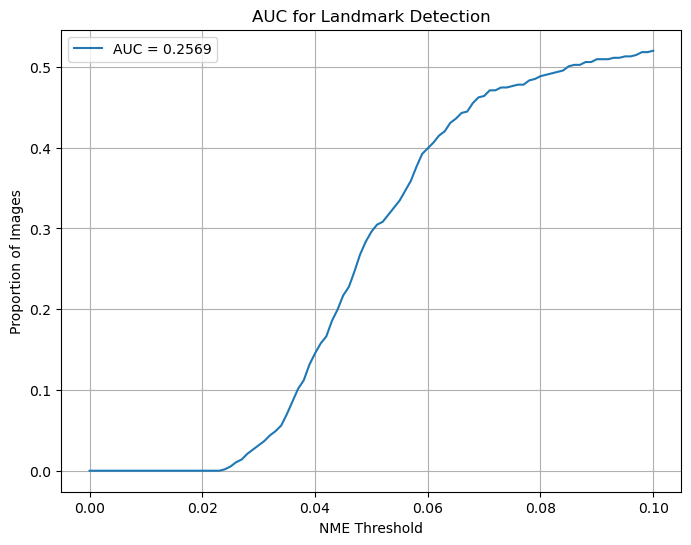

In [10]:
import os
import cv2
import dlib
import numpy as np
import glob
import matplotlib.pyplot as plt

# Đường dẫn đến model và dataset
PREDICTOR_PATH = "/home/felixng/fll/Evaluate/shape_predictor_68_face_landmarks.dat"
DATASET_PATH = "/mnt/c/Users/minht/OneDrive - VNU-HCMUS/dataset/300W"
IMAGE_EXTENSION = ['jpg', 'png']

# Load model Dlib
predictor = dlib.shape_predictor(PREDICTOR_PATH)
detector = dlib.get_frontal_face_detector()

# Hàm chuyển đổi landmarks từ dlib shape sang numpy array
def shape_to_np(shape):
    coords = np.zeros((68, 2), dtype="int")
    for i in range(68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

# Hàm tính NME
def calculate_nme(predicted, ground_truth):
    interocular_distance = np.linalg.norm(ground_truth[36] - ground_truth[45])
    error = np.mean(np.linalg.norm(predicted - ground_truth, axis=1))
    return error / interocular_distance

# Hàm tính FRE
def calculate_fre(nme, threshold=0.1):
    return 1 if nme > threshold else 0

# Hàm tính AUC
def calculate_auc(errors, threshold=0.1, step=0.001):
    x = np.arange(0, threshold + step, step)
    y = [(errors <= t).sum() / len(errors) for t in x]
    auc = np.trapz(y, x) / threshold
    return auc, x, y

# Load dữ liệu ground truth từ file .pts
def load_ground_truth(pts_file):
    points = []
    with open(pts_file) as f:
        lines = f.readlines()[3:-1]  # Bỏ qua phần header
        for line in lines:
            x, y = line.strip().split()
            points.append((float(x), float(y)))
    return np.array(points)

# Đọc danh sách ảnh từ Indoor và Outdoor
image_paths = []
for ext in IMAGE_EXTENSION:
    image_paths.extend(glob.glob(os.path.join(DATASET_PATH, "01_Indoor", f"*.{ext}")))
    image_paths.extend(glob.glob(os.path.join(DATASET_PATH, "02_Outdoor", f"*.{ext}")))

# Khởi tạo biến để tính NME, FRE
nme_list = []
fre_list = []

# Đánh giá model trên tập test
for image_path in image_paths:
    pts_path = image_path.replace('.jpg', '.pts').replace('.png', '.pts')

    if not os.path.exists(pts_path):
        print(f"Không tìm thấy file .pts cho ảnh: {image_path}")
        continue

    ground_truth = load_ground_truth(pts_path)

    # Đọc ảnh và chuyển sang grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Dò tìm khuôn mặt
    faces = detector(gray)

    if len(faces) == 0:
        print(f"Không tìm thấy khuôn mặt trong {image_path}")
        continue

    face = faces[0]
    shape = predictor(gray, face)
    predicted = shape_to_np(shape)

    # Tính NME và FRE
    nme = calculate_nme(predicted, ground_truth)
    fre = calculate_fre(nme)

    nme_list.append(nme)
    fre_list.append(fre)

# Tính AUC từ danh sách NME
nme_list = np.array(nme_list)
fre_list = np.array(fre_list)
auc, x, y = calculate_auc(nme_list)

# Kết quả tổng hợp
mean_nme = np.mean(nme_list)
failure_rate = np.mean(fre_list) * 100

print(f"NME: {mean_nme:.4f}")
print(f"FRE: {failure_rate:.2f}%")
print(f"AUC: {auc:.4f}")

# Vẽ biểu đồ AUC
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=f'AUC = {auc:.4f}')
plt.xlabel('NME Threshold')
plt.ylabel('Proportion of Images')
plt.title('AUC for Landmark Detection')
plt.legend()
plt.grid()
plt.show()
